### Testing the playground

In [1]:
import xml.etree.ElementTree as ET
root = ET.parse("Vermis.xml").getroot()

print(root)

ModelFileName = [hull[0].get("ModelFileName") for hull in root.findall("HULL/Hull")]
print(ModelFileName)

<Element 'COMPOUND' at 0x104c7e720>
['vermis0-1.mesh', 'vermis1-1.mesh', 'vermis2-1.mesh', 'vermis3-1.mesh', 'vermis1-1.mesh', 'vermis2-1.mesh', 'vermis3-1.mesh', 'vermis1-1.mesh', 'vermis2-1.mesh', 'vermis7-1.mesh', 'vermis10-0.mesh', 'vermis10-1.mesh', 'vermis10-2.mesh', 'vermis10-2.mesh', 'vermis10-4.mesh', 'vermis10-5.mesh', 'vermis10-6.mesh', 'vermis10-5.mesh', 'vermis10-6.mesh', 'vermis10-5.mesh', 'vermis10-6.mesh', 'vermis10-5.mesh', 'vermis10-6.mesh', 'vermis9-0.mesh', 'vermis9-0.mesh', 'vermis9-0.mesh', 'vermis9-0.mesh', 'vermis9-4.mesh', 'vermis9-5.mesh', 'vermis9-6.mesh', 'vermis9-7.mesh', 'vermis9-4.mesh', 'vermis9-5.mesh', 'vermis9-6.mesh', 'vermis9-7.mesh', 'vermis5-1.mesh', 'vermis5-1.mesh', 'vermis5-1.mesh', 'vermis5-1.mesh', 'vermis5-1.mesh', 'vermis5-1.mesh', 'vermis5-1.mesh', 'vermis5-1.mesh', 'vermis5-1.mesh', 'vermis5-1.mesh', 'vermis5-1.mesh', 'vermis5-1.mesh', 'vitalcore.mesh', 'vitalcore.mesh', 'vitalcore.mesh', 'vitalcore.mesh', 'vitalcore.mesh', 'vitalcore.mes

In [2]:
# This library will not be used.

from xml.dom import minidom

xmlmodel = minidom.parse("Vermis.xml")
elements = xmlmodel.getElementsByTagName("Hull")
print("No. of Hull: %s" % len(elements))

hull_types = [int(el.attributes["HullType"].value) for el in elements]
print("HullType: %s" % hull_types)

No. of Hull: 64
HullType: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1]


## Metamorphic Testing

1. Take XMLs final bosses (Vermis, octopus, etc.).

2. Parse the XMLs to take the inheritance properties of `Component`, and tag as "good".

3. Mutate the XMLs to take the inheritance properties of `Component`, and tag as "bad".

4. Merge in a CSV file. Note: 1 CSV per 1 model.

    Scale | Position | Orientation | Fitness
    :---: | :------: | :---------: |  -----
      .   |    ..    |     ...     |    1    (baseline)
      .   |    ..    |     ...     |   0.86  (mutation)

5. Tensorflow training.

In [3]:
'''
1st step.
'''

# def list_of_floats(list_):
#     return [float(item) for item in list_]
# 
# def list_of_ints(list_):
#     return [int(item) for item in list_]

def values(elements, node, tag):
    return [element[node].get(tag) for element in elements]

class Vector3(object):
    def __init__(self, x: float, y: float, z: float):
        self.x = float(x)
        self.y = float(y)
        self.z = float(z)

    def __repr__(self):  # for debugging
        return f"Vector3({self.x}, {self.y}, {self.z})"

    def __str__(self):  # for printing
        return f"{self.x}, {self.y}, {self.z}"

    def __eq__(self, other):
        """Overload equality operator."""
        if not isinstance(other, Vector3):
            return False
        return (self.x == other.x) and (self.y == other.y) and (self.z == other.z)

    def __add__(self, other):
        """Overload addition operator."""
        if isinstance(other, Vector3):
            x = self.x + other.x
            y = self.y + other.y
            z = self.z + other.z
        else:
            x = self.x + other
            y = self.y + other
            z = self.z + other
        return Vector3(x, y, z)
    
    def __sub__(self, other):
        """Overload subtraction operator."""
        if isinstance(other, Vector3):
            x = self.x - other.x
            y = self.y - other.y
            z = self.z - other.z
        else:
            x = self.x - other
            y = self.y - other
            z = self.z - other
        return Vector3(x, y, z)
    
    def __mul__(self, other):
        """Overload multiplication operator."""
        if isinstance(other, Vector3):
            x = self.x * other.x
            y = self.y * other.y
            z = self.z * other.z
        else:
            x = self.x * other
            y = self.y * other
            z = self.z * other
        return Vector3(x, y, z)

    def __truediv__(self, other):
        """Overload division operator."""
        if isinstance(other, Vector3):
            x = self.x / other.x
            y = self.y / other.y
            z = self.z / other.z
        else:
            x = self.x / other
            y = self.y / other
            z = self.z / other
        return Vector3(x, y, z)
    
    def magnitude(self):
        """Compute magnitude (length)."""
        x = self.x**2
        y = self.y**2
        z = self.z**2
        return sqrt(x + y + z)


class Quaternion(object):
    def __init__(self, w: float, x: float, y: float, z: float):
        self.w = float(w)
        self.x = float(x)
        self.y = float(y)
        self.z = float(z)

    def __repr__(self):  # for debugging
        return f"Quaternion({self.w}, {self.x}, {self.y}, {self.z})"

    def __str__(self):  # for printing
        return f"{self.w}, {self.x}, {self.y}, {self.z}"

    def __eq__(self, other):
        """Overload equality operator."""
        if not isinstance(other, Quaternion):
            return False
        return (self.w == other.w) and (self.x == other.x) and (self.y == other.y) and (self.z == other.z)

    def __add__(self, other):
        """Overload addition operator."""
        if isinstance(other, Quaternion):
            w = self.w + other.w
            x = self.x + other.x
            y = self.y + other.y
            z = self.z + other.z
        else:
            w = self.w + other
            x = self.x + other
            y = self.y + other
            z = self.z + other
        return Quaternion(w, x, y, z)
    
    def __sub__(self, other):
        """Overload subtraction operator."""
        if isinstance(other, Quaternion):
            w = self.w - other.w
            x = self.x - other.x
            y = self.y - other.y
            z = self.z - other.z
        else:
            w = self.w - other
            x = self.x - other
            y = self.y - other
            z = self.z - other
        return Quaternion(w, x, y, z)
    
    def __mul__(self, other):
        """Overload multiplication operator."""
        if isinstance(other, Quaternion):
            w = self.w * other.w
            x = self.x * other.x
            y = self.y * other.y
            z = self.z * other.z
        else:
            w = self.w * other
            x = self.x * other
            y = self.y * other
            z = self.z * other
        return Quaternion(w, x, y, z)

    def __truediv__(self, other):
        """Overload division operator."""
        if isinstance(other, Quaternion):
            w = self.w / other.w
            x = self.x / other.x
            y = self.y / other.y
            z = self.z / other.z
        else:
            w = self.w / other
            x = self.x / other
            y = self.y / other
            z = self.z / other
        return Quaternion(w, x, y, z)
    
    def magnitude(self):
        """Compute magnitude (length)."""
        w = self.w**2
        x = self.x**2
        y = self.y**2
        z = self.z**2
        return sqrt(w + x + y + z)


import xml.etree.ElementTree as ET

vermis = ET.parse("Vermis.xml").getroot()
hulls = vermis.findall("HULL/Hull")

print("No. of Hull: %s\n" % len(hulls))

scalesX = values(hulls, 0, "ScaleX")
scalesY = values(hulls, 0, "ScaleY")
scalesZ = values(hulls, 0, "ScaleZ")
scales = [Vector3(scalesX[i], scalesY[i], scalesZ[i]) for i in range(len(hulls))]

# print(f"Scales: {scales}\n")

positionsX = values(hulls, 0, "PositionX")
positionsY = values(hulls, 0, "PositionY")
positionsZ = values(hulls, 0, "PositionZ")
positions = [Vector3(positionsX[i], positionsY[i], positionsZ[i]) for i in range(len(hulls))]

# print(f"Positions: {positions}\n")

orientationsW = values(hulls, 0, "OrientationW")
orientationsX = values(hulls, 0, "OrientationX")
orientationsY = values(hulls, 0, "OrientationY")
orientationsZ = values(hulls, 0, "OrientationZ")
orientations = [Quaternion(orientationsW[i], orientationsX[i], orientationsY[i], orientationsZ[i]) for i in range(len(hulls))]

# print(f"Orientations: {orientations}\n")

class Hull(object):
    def __init__(self, scale, position, orientation):
        self.scale = scale
        self.position = position
        self.orientation = orientation
        
    def __repr__(self):
        return f"Hull(scale: <{self.scale}>, position: <{self.position}>, orientation: <{self.orientation}>)"

hulls_ = [Hull(scales[i], positions[i], orientations[i]) for i in range(len(hulls))]
for i in range(len(hulls)):
    print(f"{hulls_[i]}")

print() # newline

class Link(object):
    def __init__(self, hullIndexFirst, hullIndexSecond):
        self.hullIndexFirst = hullIndexFirst
        self.hullIndexSecond = hullIndexSecond
        
    def __repr__(self):
        return f"Link(hullIndexFirst: {self.hullIndexFirst}, hullIndexSecond: {self.hullIndexSecond})"

links = vermis.findall("HULL/LINKS/Link")

print("No. of Link: %s\n" % len(links))

hullIndexFirst = values(links, 0, "HullIndexFirst")
hullIndexSecond = values(links, 0, "HullIndexSecond")

links_ = [Link(hullIndexFirst[i], hullIndexSecond[i]) for i in range(len(links))]
for i in range(len(links)):
    print(f"{links_[i]}")

print() # newline

hullsIndexed = set()
for i in range(len(links)):
    hullsIndexed.add(int(links_[i].hullIndexFirst))
    hullsIndexed.add(int(links_[i].hullIndexSecond))
print(f"HullIndexParent (TOT-{len(hullsIndexed)}): {hullsIndexed}")

No. of Hull: 64

Hull(scale: <1.0, 1.0, 1.0>, position: <0.0, 0.0, 0.0>, orientation: <1.0, 0.0, 0.0, 0.0>)
Hull(scale: <1.0, 1.0, 1.0>, position: <0.0, 0.0, -1.850857>, orientation: <1.0, 0.0, 0.0, 0.0>)
Hull(scale: <1.24, 1.24, 1.0>, position: <0.0, 0.0, -3.81416>, orientation: <1.0, 0.0, 0.0, 0.0>)
Hull(scale: <1.5, 1.5, 0.93>, position: <0.0, 0.0, -5.792092>, orientation: <1.0, 0.0, 0.0, 0.0>)
Hull(scale: <0.74, 0.74, 1.0>, position: <0.0, 0.0, -7.736513>, orientation: <1.0, 0.0, 0.0, 0.0>)
Hull(scale: <0.93, 0.93, 0.93>, position: <0.0, 0.0, -9.630841>, orientation: <1.0, 0.0, 0.0, 0.0>)
Hull(scale: <1.14, 1.14, 0.84>, position: <0.0, 0.0, -11.460143>, orientation: <1.0, 0.0, 0.0, 0.0>)
Hull(scale: <0.53, 0.53, 0.86>, position: <0.0, 0.0, -13.193>, orientation: <1.0, 0.0, 0.0, 0.0>)
Hull(scale: <0.6, 0.6, 0.75>, position: <0.0, 0.0, -14.799787>, orientation: <1.0, 0.0, 0.0, 0.0>)
Hull(scale: <1.0, 1.0, 1.0>, position: <0.0, 0.0, 0.8008>, orientation: <1.0, 0.0, 0.0, 0.0>)
Hull(sca

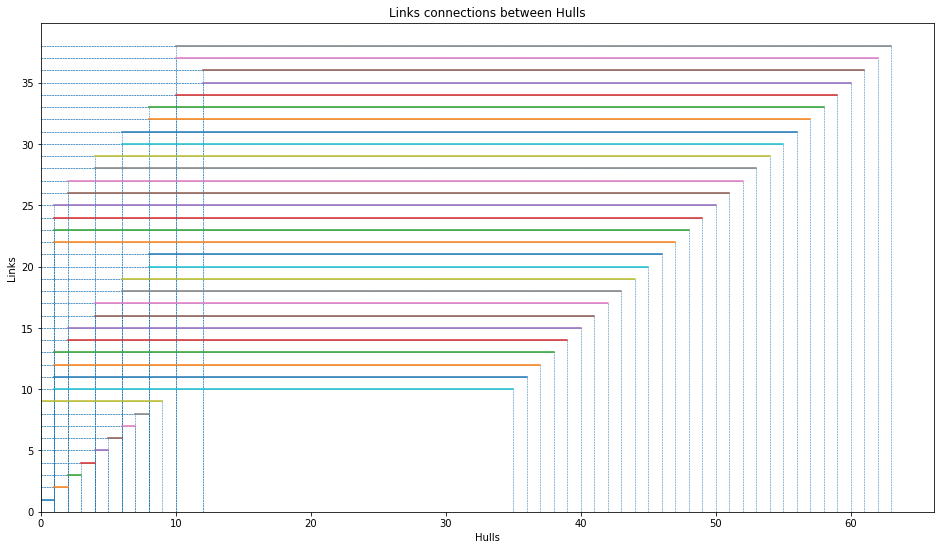

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))

for j in range(len(links)):
    x = [int(links_[j].hullIndexFirst), int(links_[j].hullIndexSecond)]
    y = [j + 1, j + 1]
    plt.vlines(x, 0, y, linestyle="dashed", linewidth=0.5)
    plt.hlines(y, 0, x, linestyle="dashed", linewidth=0.5)
    plt.plot(x, y, label = f"Link-{j}")

plt.xlim(0, None)
plt.ylim(0, None)

plt.xlabel("Hulls")
plt.ylabel("Links")

plt.title("Links connections between Hulls")

plt.show()

In [5]:
dataset_ = []

for j in range(len(links)):
    hullIndexFirst = int(links_[j].hullIndexFirst)
    hullIndexSecond = int(links_[j].hullIndexSecond)

    dataset_.append({"Name": "vermis-baseline",
           "HullIndexFirst": hullIndexFirst,
           "HIF-ScaleX": hulls_[hullIndexFirst].scale.x,
           "HIF-ScaleY": hulls_[hullIndexFirst].scale.y,
           "HIF-ScaleZ": hulls_[hullIndexFirst].scale.z,
           "HIF-PositionX": hulls_[hullIndexFirst].position.x,
           "HIF-PositionY": hulls_[hullIndexFirst].position.y,
           "HIF-PositionZ": hulls_[hullIndexFirst].position.z,
           "HIF-OrientationW": hulls_[hullIndexFirst].orientation.w,
           "HIF-OrientationX": hulls_[hullIndexFirst].orientation.x,
           "HIF-OrientationY": hulls_[hullIndexFirst].orientation.y,
           "HIF-OrientationZ": hulls_[hullIndexFirst].orientation.z,
           "HullIndexSecond": hullIndexSecond,
           "HIS-ScaleX": hulls_[hullIndexSecond].scale.x,
           "HIS-ScaleY": hulls_[hullIndexSecond].scale.y,
           "HIS-ScaleZ": hulls_[hullIndexSecond].scale.z,
           "HIS-PositionX": hulls_[hullIndexSecond].position.x,
           "HIS-PositionY": hulls_[hullIndexSecond].position.y,
           "HIS-PositionZ": hulls_[hullIndexSecond].position.z,
           "HIS-OrientationW": hulls_[hullIndexSecond].orientation.w,
           "HIS-OrientationX": hulls_[hullIndexSecond].orientation.x,
           "HIS-OrientationY": hulls_[hullIndexSecond].orientation.y,
           "HIS-OrientationZ": hulls_[hullIndexSecond].orientation.z,
           "Fitness": 1})

In [6]:
import csv

def export_dataset_to_csv(dataset, filename, verbose=True):
    with open(filename + ".csv", mode='w') as file:
        fieldnames = ["Name",
                  "HullIndexFirst",
                  "HIF-ScaleX",
                  "HIF-ScaleY",
                  "HIF-ScaleZ",
                  "HIF-PositionX",
                  "HIF-PositionY",
                  "HIF-PositionZ",
                  "HIF-OrientationW",
                  "HIF-OrientationX",
                  "HIF-OrientationY",
                  "HIF-OrientationZ",
                  "HullIndexSecond",
                  "HIS-ScaleX",
                  "HIS-ScaleY",
                  "HIS-ScaleZ",
                  "HIS-PositionX",
                  "HIS-PositionY",
                  "HIS-PositionZ",
                  "HIS-OrientationW",
                  "HIS-OrientationX",
                  "HIS-OrientationY",
                  "HIS-OrientationZ",
                  "Fitness"]

        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()

        for row in dataset:
            if verbose: print(f"{row}\n")
            writer.writerow(row)

export_dataset_to_csv(dataset_, filename="vermis_dataset")

ationW': 1.0, 'HIF-OrientationX': 0.0, 'HIF-OrientationY': 0.0, 'HIF-OrientationZ': 0.0, 'HullIndexSecond': 2, 'HIS-ScaleX': 1.24, 'HIS-ScaleY': 1.24, 'HIS-ScaleZ': 1.0, 'HIS-PositionX': 0.0, 'HIS-PositionY': 0.0, 'HIS-PositionZ': -3.81416, 'HIS-OrientationW': 1.0, 'HIS-OrientationX': 0.0, 'HIS-OrientationY': 0.0, 'HIS-OrientationZ': 0.0, 'Fitness': 1}

{'Name': 'vermis-baseline', 'HullIndexFirst': 2, 'HIF-ScaleX': 1.24, 'HIF-ScaleY': 1.24, 'HIF-ScaleZ': 1.0, 'HIF-PositionX': 0.0, 'HIF-PositionY': 0.0, 'HIF-PositionZ': -3.81416, 'HIF-OrientationW': 1.0, 'HIF-OrientationX': 0.0, 'HIF-OrientationY': 0.0, 'HIF-OrientationZ': 0.0, 'HullIndexSecond': 3, 'HIS-ScaleX': 1.5, 'HIS-ScaleY': 1.5, 'HIS-ScaleZ': 0.93, 'HIS-PositionX': 0.0, 'HIS-PositionY': 0.0, 'HIS-PositionZ': -5.792092, 'HIS-OrientationW': 1.0, 'HIS-OrientationX': 0.0, 'HIS-OrientationY': 0.0, 'HIS-OrientationZ': 0.0, 'Fitness': 1}

{'Name': 'vermis-baseline', 'HullIndexFirst': 3, 'HIF-ScaleX': 1.5, 'HIF-ScaleY': 1.5, 'HIF-ScaleZ

In [7]:
import random
import numpy as np

''' Subjects a given value to a mutation process.

The result of the mutation can be: (0) value incremented by a percent,
(1) value decremented by a percent, or (2) default value.

:param value: input value
:type value: float
:param percentage: mutation's percent
:type percentage: int
:returns: mutated value
:rtype: float
'''
def mutate_value(value: float, percentage: int) -> float:
    mutation = random.randrange(0, 2 + 1, 1) # value range: (0, 1, 2)
    
    if mutation == 0: # incremental mutation
        return float(value + value * (percentage / 100))
    elif mutation == 1: # decremental mutation
        return float(value - value * (percentage / 100))
    else: return value


''' Subjects a given set of properties belonging to an specific dataset to a mutation process.

Usage:
  1. mutate_props(dataset_, props=props, percentage=[10, 15])
  2. mutate_props(dataset_, props=props, percentage=14)

:param dataset: input dataset
:type dataset: dictionary array
:param props: set of properties
:type props: str array
:param percentage: mutation's percent
:type percentage: int or list
:returns: mutated dataset
:rtype: dictionary array
'''
def mutate_props(dataset, props, percentage, index=0, verbose=True):
    if not isinstance(percentage, (int, list)):
        return

    dataset_mut = []
    
    isrange = True if isinstance(percentage, list) else False
    percentage_ = random.randrange(percentage[0], percentage[1] + 1, 1) if isinstance(percentage, list) else percentage
    
    for row in dataset:
        data = row.copy()
        
        if isrange:
            percentage_ = random.randrange(percentage[0], percentage[1] + 1, 1)
        
        for prop in props:
            if verbose: print(f"Link-{index}_{prop}: " + "{:.2f} -> ".format(row[prop]), end='')
            data[prop] = mutate_value(row[prop], percentage_)
            if verbose: print("{:.2f}".format(row[prop]) + f" ({percentage_}%)")
        
        data["Name"] = data["Name"].replace("baseline", "mutated")
        data["Fitness"] = 1 - percentage_ / 100
        if verbose: print(f"Link-{index}_Fitness: " + "{:.2f}\n".format(row["Fitness"]))
        
        dataset_mut.append(data)
        
        index += 1
    
    return dataset_mut


''' Subjects a given model to a mutation process.

:param dataset: input dataset
:type dataset: dictionary array
:param props: set of properties
:type props: str array
:param percentage: mutation's percent
:type percentage: int or list
:param times: number of times the mutation is performed (default: 1)
:type times: int
:param filename: name of the csv file where to export the dataset (default: None)
:type filename: str
'''
def mutate_model(dataset, props, percentage, times=1, filename=None, verbose=True):
    dataset_all = np.array(dataset[:])
    
    for t in range(times):
        dataset_mut = np.array(mutate_props(dataset[:], props, percentage, verbose=verbose))
        dataset_all = np.concatenate((dataset_all, dataset_mut))
    
    if filename is not None:
        export_dataset_to_csv(dataset_all, filename, verbose=verbose)

props = ["HIF-ScaleX", "HIF-ScaleY", "HIF-ScaleZ",
         "HIS-ScaleX", "HIS-ScaleY", "HIS-ScaleZ",
         "HIF-PositionX", "HIF-PositionY", "HIF-PositionZ",
         "HIS-PositionX", "HIS-PositionY", "HIS-PositionZ"]

mutate_model(dataset_, props=props, percentage=[10, 15], times=49, filename="vermis_dataset_mut", verbose=False)